<a href="https://colab.research.google.com/github/furkantprk/AntivirusProgram/blob/main/Diginova_proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
from google.colab import files

!pip install --upgrade pip
!pip install kaggle --quiet
!pip install opencv-python-headless scikit-image imutils --quiet

files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content --unzip

print("TensorFlow version:", tf.__version__)

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 93% 567M/612M [00:03<00:00, 137MB/s]
100% 612M/612M [00:03<00:00, 169MB/s]
TensorFlow version: 2.19.0


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

DATA_DIR = '/content'

images = []
labels = []


train_dir = os.path.join(DATA_DIR, 'Train')
if not os.path.isdir(train_dir):
    print(f"HATA: Train dizini beklenildiği yerde bulunamadı: {train_dir}")
else:
    for class_id in sorted(os.listdir(train_dir)):
        class_path = os.path.join(train_dir, class_id)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            try:
                image = cv2.imread(fpath)
                if image is None:
                    continue

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (32, 32))

                images.append(image)
                labels.append(int(class_id))
            except Exception as e:
                pass

images = np.array(images, dtype="float32")
labels = np.array(labels, dtype="int")
print("Loaded images:", images.shape, "labels:", labels.shape)

images /= 255.0
num_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes)

X_train, X_val, y_train, y_val = train_test_split(images, labels_cat, test_size=0.2, random_state=42, stratify=labels)
print("Train:", X_train.shape, "Val:", X_val.shape)

Loaded images: (39209, 32, 32, 3) labels: (39209,)
Train: (31367, 32, 32, 3) Val: (7842, 32, 32, 3)


In [ ]:
from tensorflow.keras import layers, models, regularizers

def build_traffic_sign_net(input_shape=(32,32,3), num_classes=43):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=input_shape, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.0001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(num_classes, activation="softmax"))
    return model

model = build_traffic_sign_net(input_shape=X_train.shape[1:], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,339 (4.45 MB)

 Trainable params: 1,165,867 (4.45 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1667 - loss: 3.9424
Epoch 1: val_accuracy improved from -inf to 0.24012, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.1669 - loss: 3.9407 - val_accuracy: 0.2401 - val_loss: 2.9929 - learning_rate: 0.0010
Epoch 2/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5042 - loss: 1.7234
Epoch 2: val_accuracy improved from 0.24012 to 0.72749, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.5043 - loss: 1.7231 - val_accuracy: 0.7275 - val_loss: 0.9992 - learning_rate: 0.0010
Epoch 3/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6486 - loss: 1.2218
Epoch 3: val_accuracy improved from 0.72749 to 0.86521, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6486 - loss: 1.2217 - val_accuracy: 0.8652 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 4/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7310 - loss: 0.9693
Epoch 4: val_accuracy improved from 0.86521 to 0.89760, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7311 - loss: 0.9692 - val_accuracy: 0.8976 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 5/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7830 - loss: 0.8217
Epoch 5: val_accuracy improved from 0.89760 to 0.95231, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7830 - loss: 0.8217 - val_accuracy: 0.9523 - val_loss: 0.3403 - learning_rate: 0.0010
Epoch 6/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8189 - loss: 0.7235
Epoch 6: val_accuracy improved from 0.95231 to 0.96378, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8189 - loss: 0.7235 - val_accuracy: 0.9638 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 7/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8414 - loss: 0.6554
Epoch 7: val_accuracy improved from 0.96378 to 0.97526, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8414 - loss: 0.6554 - val_accuracy: 0.9753 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 8/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8535 - loss: 0.6479
Epoch 8: val_accuracy improved from 0.97526 to 0.97845, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8535 - loss: 0.6478 - val_accuracy: 0.9784 - val_loss: 0.2931 - learning_rate: 0.0010
Epoch 9/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8702 - loss: 0.6127
Epoch 9: val_accuracy improved from 0.97845 to 0.98495, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.8702 - loss: 0.6127 - val_accuracy: 0.9850 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 10/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8827 - loss: 0.5872
Epoch 10: val_accuracy did not improve from 0.98495
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8827 - loss: 0.5872 - val_accuracy: 0.9837 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 11/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8899 - loss: 0.5786
Epoch 11: val_accuracy improved from 0.98495 to 0.98789, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8899 - loss: 0.5786 - val_accuracy: 0.9879 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 12/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8964 - loss: 0.5651
Epoch 12: val_accuracy did not improve from 0.98789
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8964 - loss: 0.5651 - val_accuracy: 0.9821 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 13/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8973 - loss: 0.5721
Epoch 13: val_accuracy improved from 0.98789 to 0.99171, saving model to /content/trafficsign_model.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8973 - loss: 0.5721 - val_accuracy: 0.9917 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 14/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9114 - loss: 0.5374
Epoch 14: val_accuracy improved from 0.99171 to 0.99324, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9114 - loss: 0.5373 - val_accuracy: 0.9932 - val_loss: 0.2930 - learning_rate: 5.0000e-04
Epoch 15/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9228 - loss: 0.4909
Epoch 15: val_accuracy did not improve from 0.99324
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9228 - loss: 0.4909 - val_accuracy: 0.9931 - val_loss: 0.2826 - learning_rate: 5.0000e-04
Epoch 16/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9294 - loss: 0.4673
Epoch 16: val_accuracy improved from 0.99324 to 0.99388, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9294 - loss: 0.4673 - val_accuracy: 0.9939 - val_loss: 0.2721 - learning_rate: 5.0000e-04
Epoch 17/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9276 - loss: 0.4652
Epoch 17: val_accuracy improved from 0.99388 to 0.99452, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9276 - loss: 0.4652 - val_accuracy: 0.9945 - val_loss: 0.2642 - learning_rate: 5.0000e-04
Epoch 18/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9334 - loss: 0.4417
Epoch 18: val_accuracy improved from 0.99452 to 0.99464, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9334 - loss: 0.4417 - val_accuracy: 0.9946 - val_loss: 0.2603 - learning_rate: 5.0000e-04
Epoch 19/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9356 - loss: 0.4280
Epoch 19: val_accuracy did not improve from 0.99464
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9356 - loss: 0.4280 - val_accuracy: 0.9922 - val_loss: 0.2579 - learning_rate: 5.0000e-04
Epoch 20/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9352 - loss: 0.4257
Epoch 20: val_accuracy improved from 0.99464 to 0.99681, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9352 - loss: 0.4257 - val_accuracy: 0.9968 - val_loss: 0.2409 - learning_rate: 5.0000e-04
Epoch 21/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9421 - loss: 0.4051
Epoch 21: val_accuracy did not improve from 0.99681
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9420 - loss: 0.4051 - val_accuracy: 0.9968 - val_loss: 0.2377 - learning_rate: 5.0000e-04
Epoch 22/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9345 - loss: 0.4162
Epoch 22: val_accuracy improved from 0.99681 to 0.99694, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9345 - loss: 0.4162 - val_accuracy: 0.9969 - val_loss: 0.2319 - learning_rate: 5.0000e-04
Epoch 23/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9385 - loss: 0.4022
Epoch 23: val_accuracy did not improve from 0.99694
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9385 - loss: 0.4022 - val_accuracy: 0.9902 - val_loss: 0.2466 - learning_rate: 5.0000e-04
Epoch 24/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9452 - loss: 0.3849
Epoch 24: val_accuracy improved from 0.99694 to 0.99719, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9452 - loss: 0.3849 - val_accuracy: 0.9972 - val_loss: 0.2258 - learning_rate: 5.0000e-04
Epoch 25/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9388 - loss: 0.3944
Epoch 25: val_accuracy improved from 0.99719 to 0.99732, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9388 - loss: 0.3944 - val_accuracy: 0.9973 - val_loss: 0.2244 - learning_rate: 5.0000e-04
Epoch 26/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9374 - loss: 0.4015
Epoch 26: val_accuracy did not improve from 0.99732
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9374 - loss: 0.4014 - val_accuracy: 0.9938 - val_loss: 0.2314 - learning_rate: 5.0000e-04
Epoch 27/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9422 - loss: 0.3880
Epoch 27: val_accuracy did not improve from 0.99732
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9422 - loss: 0.3879 - val_accuracy: 0.9969 - val_loss: 0.2197 - learning_rate: 5.0000e-04
Epoch 28/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9465 - loss: 0.3672
Epoch 28: val_accuracy did not improve from 0.99732
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9465 - loss: 0.3673 - val_accuracy: 0.9948 - val_loss: 0.2273 - learning_rate: 5.0

491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9440 - loss: 0.3797 - val_accuracy: 0.9974 - val_loss: 0.2172 - learning_rate: 5.0000e-04
Epoch 31/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9504 - loss: 0.3637
Epoch 31: val_accuracy did not improve from 0.99745
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9504 - loss: 0.3637 - val_accuracy: 0.9972 - val_loss: 0.2169 - learning_rate: 5.0000e-04
Epoch 32/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9489 - loss: 0.3581
Epoch 32: val_accuracy did not improve from 0.99745
491/491 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9489 - loss: 0.3581 - val_accuracy: 0.9963 - val_loss: 0.2174 - learning_rate: 5.0000e-04
Epoch 33/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9435 - loss: 0.3747
Epoch 33: val_accuracy did not improve from 0.99745
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9435 - loss: 0.3747 - val_accuracy: 0.9972 - val_loss: 0.2144 - learning_rate: 5.0

491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9509 - loss: 0.3556 - val_accuracy: 0.9977 - val_loss: 0.2120 - learning_rate: 5.0000e-04
Epoch 36/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9481 - loss: 0.3583
Epoch 36: val_accuracy did not improve from 0.99770
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9481 - loss: 0.3583 - val_accuracy: 0.9972 - val_loss: 0.2135 - learning_rate: 5.0000e-04
Epoch 37/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9495 - loss: 0.3577
Epoch 37: val_accuracy did not improve from 0.99770
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9495 - loss: 0.3577 - val_accuracy: 0.9972 - val_loss: 0.2105 - learning_rate: 5.0000e-04
Epoch 38/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9488 - loss: 0.3470
Epoch 38: val_accuracy improved from 0.99770 to 0.99796, saving model to /content/trafficsign_model.h5


491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9488 - loss: 0.3470 - val_accuracy: 0.9980 - val_loss: 0.2077 - learning_rate: 5.0000e-04
Epoch 39/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9486 - loss: 0.3507
Epoch 39: val_accuracy did not improve from 0.99796
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9486 - loss: 0.3507 - val_accuracy: 0.9972 - val_loss: 0.2077 - learning_rate: 5.0000e-04
Epoch 40/40
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9475 - loss: 0.3571
Epoch 40: val_accuracy did not improve from 0.99796
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9475 - loss: 0.3571 - val_accuracy: 0.9977 - val_loss: 0.2075 - learning_rate: 5.0000e-04


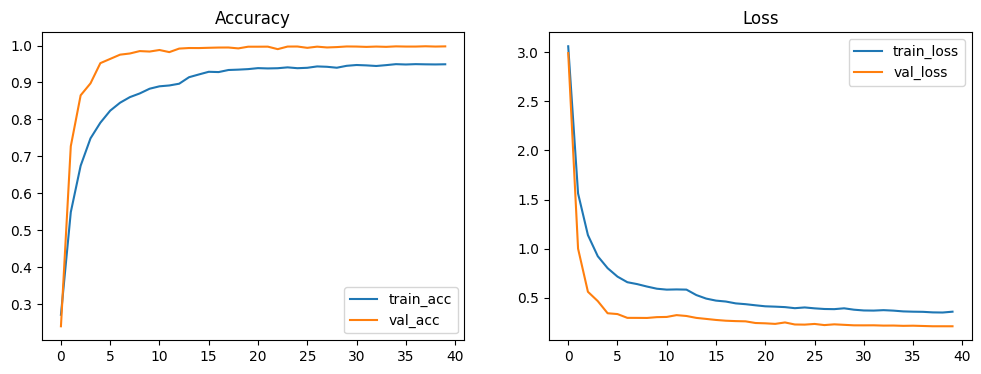

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

checkpoint_path = "/content/trafficsign_model.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=callbacks,
    verbose=1
)

# 🔹 Grafik çizimi
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
model.save('/content/trafficsign_model_savedmodel.keras')
model.save('/content/trafficsign_model_best.h5')
print("Saved model to /content")

Saved model to /content


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

model_inf = load_model('/content/trafficsign_model_best.h5')

def predict_sign(image_path, model=model_inf, input_size=(32,32)):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, input_size)
    img_resized = img_resized.astype("float32") / 255.0
    x = np.expand_dims(img_resized, axis=0)
    probs = model.predict(x)[0]
    idx = np.argmax(probs)
    prob = float(probs[idx])
    return {"class_id": int(idx), "probability": prob}

In [ ]:
for i in range(0,43):
    path = f"/content/Meta/{i}.png"
    sonuc = predict_sign(path)
    print(f"{i}.png -> {sonuc}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.png -> {'class_id': 16, 'probability': 0.9943002462387085}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1.png -> {'class_id': 16, 'probability': 0.9994451403617859}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2.png -> {'class_id': 16, 'probability': 0.9988988637924194}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3.png -> {'class_id': 16, 'probability': 0.9994668364524841}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4.png -> {'class_id': 16, 'probability': 0.9980009198188782}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5.png -> {'class_id': 16, 'probability': 0.9994708299636841}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6.png -> {'class_id': 16, 'probability': 0.9106577038764954}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7.png -> {'class_id': 16, 'probability': 0.9087607860565186}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8.png -> {'class_id': 16, 'probability': 0.9806092381477356}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
9.png -> {'class_id': 9, 'probability': 0.6778040528297424}
1/1 ━━━━━━━